In [216]:
import librosa
import librosa.display
import os
import os.path
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
import IPython.display as ipd
from pydub import AudioSegment

## Chuyển các file từ m4a thành wav

Không cần phải đổi `.m4a` thành `.wav` vì:
- cài đặt thêm `ffmpeg` để hỗ trợ thêm nhiều codec
- size của `.wav` rất lớn
- tốc độ đọc `.m4a` không chênh lệch nhiều
- kết quả đọc là như nhau

In [2]:
# print(os.getcwd())
# path = "songs/train/m4a/"

In [20]:
'''
Thay đổi (31/10):
* Không dùng os.chdir() để thay đổi current working directory mặc định
* Thay vào đó sử dụng path để dễ dàng convert và thực thi code phía dưới
'''
# audio_files = os.listdir(path)
# for file in audio_files:
#     file_path = path+file
#     name, ext = os.path.splitext(file)
#     if ext == ".m4a":
#         m4a_sound = AudioSegment.from_file(file_path, "m4a")
#         m4a_sound.export("./songs/train/wav/{0}.wav".format(name), format="wav") #đổi đường ổ tương nhé các gs

## EDA

In [373]:
# Các gs đổi thư mục chứa .m4a tại đây
training_dir = 'songs/train/' ####

training_files = [os.path.join(training_dir, f) for f in os.listdir(training_dir)]
print("#file:", len(training_files))

#file: 41


In [376]:
# Đọc 10s đầu của đoạn nhạc
# có thể thay đổi `index` của training_files[index]
print(training_files[0])
sample, sr = librosa.load(training_files[0], duration=10)

# Khi đọc `.m4a` sẽ bị cảnh báo, tuy nhiên không cần phải lo lắng
# Đơn giản nó chỉ đổi thư viện đọc sang `audioread`
# Xem thêm: https://librosa.org/doc/main/troubleshooting.html#pysoundfile-failed

songs/train/3107-W_n_Duongg_Nau.m4a


In [375]:
ipd.Audio(sample, rate=sr)

In [377]:
plt.rcParams['figure.figsize'] = (15, 4)

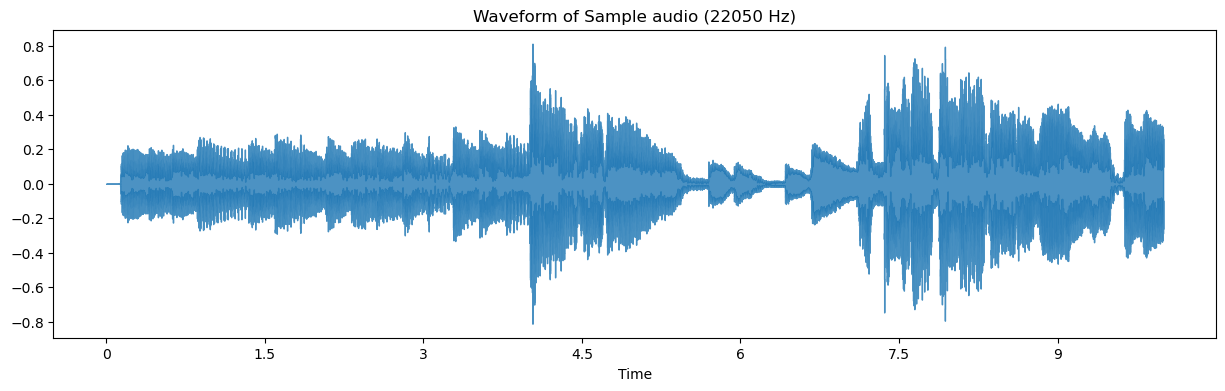

In [378]:
plt.figure()
librosa.display.waveshow(sample, sr=sr, alpha=0.8)
plt.title("Waveform of Sample audio ({} Hz)".format(sr))
plt.show()

In [379]:
# Áp dụng biến đổi Fourier để xem cường độ tần số
X = librosa.stft(sample)
spec = librosa.amplitude_to_db(np.abs(X))

# Trích xuất đặc trưng Chroma
# Đặc trưng này gồm 12 nốt nhạc: C, C#, D,..., B, C
chroma = librosa.feature.chroma_stft(y=sample, sr=sr)

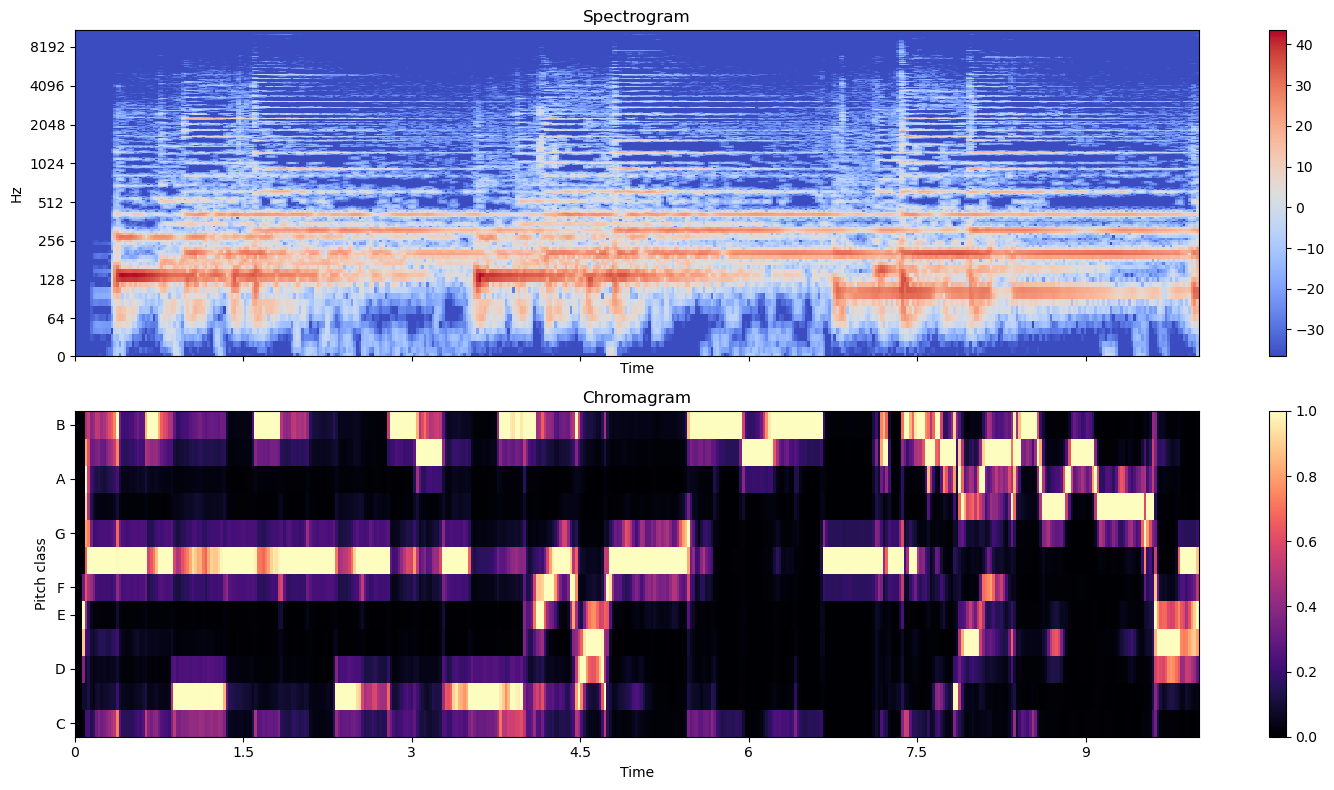

In [380]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15,8))

spec_img = librosa.display.specshow(Xmag, sr=sr, x_axis='time', y_axis='log',ax=ax[0])
ax[0].set(title="Spectrogram")
fig.colorbar(spec_img, ax=ax[0], orientation='vertical', shrink=1)

chroma_img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(title='Chromagram')
fig.colorbar(chroma_img, ax=ax[1], orientation='vertical', shrink=1)

plt.tight_layout()
plt.show()

## MusicSearch

In [255]:
training_dir = 'songs/train' # Nhớ đổi thư mục tương ứng
training_files = [os.path.join(training_dir, f) for f in os.listdir(training_dir)]
print(len(training_files))

41


In [256]:
def hash_func(vecs, projections):
    bools = np.dot(vecs, projections.T) > 0
    return [bool2int(bool_vec) for bool_vec in bools]

In [257]:
def bool2int(x):
    y = 0
    for i,j in enumerate(x):
        if j: y += 1<<i
    return y

In [258]:
bool2int([True, True, False, False])

3

In [259]:
X = np.random.randn(10,100)
P = np.random.randn(3,100)
hash_func(X, P)

[6, 2, 0, 0, 7, 7, 7, 6, 5, 7]

In [260]:
class Table:
    def __init__(self, hash_size, dim):
        self.table = dict()
        self.hash_size = hash_size
        self.projections =  np.random.randn(self.hash_size, dim)

    def add(self, vecs, label):
        entry = {'label': label}
        hashes = hash_func(vecs, self.projections)
        for h in hashes:
            if self.table.__contains__(h):
                self.table[h].append(entry)
            else:
                self.table[h] = [entry]

    def query(self, vecs):
        hashes = hash_func(vecs, self.projections)
        results = list()
        for h in hashes:
            if self.table.__contains__(h):
                results.extend(self.table[h])
        return results

In [261]:
class LSH:
    def __init__(self, dim):
        self.num_tables = 4
        self.hash_size = 8
        self.tables = list()
        for i in range(self.num_tables):
            self.tables.append(Table(self.hash_size, dim))
    
    def add(self, vecs, label):
        for table in self.tables:
            table.add(vecs, label)
    
    def query(self, vecs):
        results = list()
        for table in self.tables:
            results.extend(table.query(vecs))
        return results

    def describe(self):
        for table in self.tables:
            print(table.table)

In [262]:
class MusicSearch:
    
    def __init__(self, training_files):
        self.frame_size = 4096
        self.hop_size = 4000
        self.fv_size = 12
        self.lsh = LSH(self.fv_size)
        self.training_files = training_files
        self.num_features_in_file = dict()
        for f in self.training_files:
            self.num_features_in_file[f] = 0
                
    def train(self):
        for filepath in self.training_files:
            x, fs = librosa.load(filepath)
            features = librosa.feature.chroma_stft(x, fs, n_fft=self.frame_size, hop_length=self.hop_size).T
            self.lsh.add(features, filepath)
            self.num_features_in_file[filepath] += len(features)
            
    def query_by_filepath(self, filepath):
        '''
        Hàm này query theo filepath:
        * Đọc audio file:
            - x: Audio time series
            - fs: sampling rate (mặc định: 22050 Hz)
        
        
        '''
        x, fs = librosa.load(filepath)
        features = librosa.feature.chroma_stft(x, fs, n_fft=self.frame_size, hop_length=self.hop_size).T
        results = self.lsh.query(features)
        print('num results '+ str(len(results)))

        counts = dict()
        for r in results:
            if counts.__contains__(r['label']):
                counts[r['label']] += 1
            else:
                counts[r['label']] = 1
        for k in counts:
            counts[k] = float(counts[k])/self.num_features_in_file[k]
        return counts
    
    def query(self, x, fs):
        features = librosa.feature.chroma_stft(x, fs, n_fft=self.frame_size, hop_length=self.hop_size).T
        results = self.lsh.query(features)
        print('num results '+ str(len(results)))

        counts = dict()
        for r in results:
            if counts.__contains__(r['label']):
                counts[r['label']] += 1
            else:
                counts[r['label']] = 1
        for k in counts:
            counts[k] = float(counts[k])/self.num_features_in_file[k]
        return counts

In [319]:
training_files[0:10]

['songs/train\\3107-W_n_Duongg_Nau.m4a',
 'songs/train\\AnhSeThay-WendyThao.m4a',
 'songs/train\\AroundMyNeck-FINNEAS.m4a',
 'songs/train\\BanThanOi-Wxrdie_Droppy.m4a',
 'songs/train\\CHACEMDAKHOCRATNHIEU-YangT_BWEED.m4a',
 'songs/train\\CinnamonGirl-NeilYoung.m4a',
 'songs/train\\DayLaRapViet2-Wowy_Karik_Binz_R.m4a',
 'songs/train\\DemQuaAnhGoiPhoneChoAi-YenLe.m4a',
 'songs/train\\DemTan-Wowy_J_T_AKhanhLe.m4a',
 'songs/train\\DuongVeXaTham-VuPhuong.m4a']

In [318]:
ms = MusicSearch(training_files[0:10])
start = time.time()
ms.train()
print(time.time()-start)

92.98597502708435


In [369]:
test_file = 'songs/train\DayLaRapViet2-Wowy_Karik_Binz_R.m4a'
test_sample, test_sr = librosa.load(test_file, offset=40, duration=5)

In [370]:
len(test_sample)

110250

In [371]:
results = ms.query(test_sample, test_sr)
#results = ms.query(tese_file)

num results 151053


In [372]:
sorted_song_by_results = sorted(results, key=results.get, reverse=True)
idx = 0
for r in sorted_song_by_results:
    print("{} | {} | {}".format(idx, r, results[r]))
    idx += 1

0 | songs/train\DemTan-Wowy_J_T_AKhanhLe.m4a | 20.109437751004016
1 | songs/train\DayLaRapViet2-Wowy_Karik_Binz_R.m4a | 19.640163098878695
2 | songs/train\CinnamonGirl-NeilYoung.m4a | 18.484031936127746
3 | songs/train\AroundMyNeck-FINNEAS.m4a | 15.988648090815273
4 | songs/train\CHACEMDAKHOCRATNHIEU-YangT_BWEED.m4a | 12.653566229985444
5 | songs/train\BanThanOi-Wxrdie_Droppy.m4a | 11.521668029435814
6 | songs/train\DemQuaAnhGoiPhoneChoAi-YenLe.m4a | 10.635698198198199
7 | songs/train\3107-W_n_Duongg_Nau.m4a | 7.854134165366615
8 | songs/train\DuongVeXaTham-VuPhuong.m4a | 7.324797843665769
9 | songs/train\AnhSeThay-WendyThao.m4a | 5.6276223776223775


In [366]:
ipd.Audio(test_sample, rate=test_sr)

In [367]:
print("1st result: ", sorted_song_by_results[0])
ipd.Audio(sorted_song_by_results[0])

1st result:  songs/train\DemTan-Wowy_J_T_AKhanhLe.m4a


In [368]:
print("2nd result: ", sorted_song_by_results[1])
ipd.Audio(sorted_song_by_results[1])

2nd result:  songs/train\DayLaRapViet2-Wowy_Karik_Binz_R.m4a


### Testing: 
Bad Habits - Ed Sheraan.wav 